# Kickstarter Project

# Business Understanding

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sms
import copy
import glob

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from IPython.display import Image
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.datasets import load_boston
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import PolynomialFeatures
from scipy.special import boxcox1p
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error

In [3]:

tabelle = pd.read_excel('List_features_EDA.xlsx', sheet_name = 'Jupyter', na_values = ['.','*'])

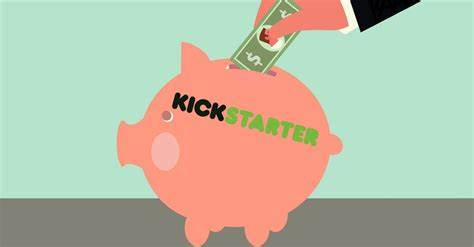

In [4]:
from IPython.display import Image
Image ('Schwein_ks.jpg')

## Einlesen der csv-Datei

In [5]:
# Einlesen der csv-Datei

import glob
import pandas as pd
# get data file names
path =r'/Users/brittarover/nf-sep-2020/Projekt_2/data'
filenames = glob.glob(path + "/*.csv")
dfs = []
for filename in filenames:
       dfs.append(pd.read_csv(filename))
# Concatenate all data into one DataFrame
df = pd.concat(dfs, ignore_index=True)

# Data Cleaning

## Check for nullvalues
The check shows that the following features: friends, is_backing, is_starred and permissions can be dropped due to missing data issue.

In [17]:
# checking null values
nan = pd.DataFrame(df.isnull().sum(),columns=['Count'])
nan['Percentage'] = round(nan.Count/df.shape[0]*100,1)
print(nan[nan.Count!=0])

              Count  Percentage
blurb             2         0.0
friends      192664       100.0
is_backing   192664       100.0
is_starred   192664       100.0
location        215         0.1
permissions  192664       100.0
usd_type         38         0.0


## Check for duplicates
No relevant duplicate.

In [18]:
# generate count statistics of duplicate entries
if len(df[df.duplicated()]) > 0:
    print("No. of duplicated entries: ", len(df[df.duplicated()]))
    print(df[df.duplicated(keep=False)].sort_values(by=list(df.columns)).head())
else:
    print("No duplicated entries found")

No duplicated entries found


## Check for outliners

## Check and change of the datatypes

### Datetime Issues
We change the features deadline and launched_at and create a new feature duration later. The dates created_at and state_changed_at are dropped.

#### Feature deadline

In [19]:
# change Date-times deadline
df['deadline'] = pd.to_datetime(df['deadline'], unit='s')

In [20]:
# split date to year and month and delete deadline later 
df['year_deadline'] = df['deadline'].dt.year 
df['month_deadline'] = df['deadline'].dt.month 
df['day_deadline'] = df['deadline'].dt.day
df['time_deadline'] = df['deadline'].dt.time

#### Feature launched_at

In [21]:
# change Date-times launched_at
df['launched_at'] = pd.to_datetime(df['launched_at'], unit='s')

In [22]:
# split date to year and month and delete deadline later 
df['year_launched'] = df['launched_at'].dt.year 
df['month_launched'] = df['launched_at'].dt.month 
df['day_launched'] = df['launched_at'].dt.day
df['time_launched'] = df['launched_at'].dt.time

In [61]:
# Launch day of week
df['day_launched'] = df['launched_at'].dt.weekday_name
df.day_launched.value_counts()

Tuesday      39755
Monday       34135
Wednesday    33802
Thursday     29531
Friday       28500
Saturday     14807
Sunday       12134
Name: day_launched, dtype: int64

##  Datachange due to inconsistency reasons

### Feature goal_USD


In [23]:
# The information in feature goal has different currencies. This needs to be changed
df["goal_usd"]=df["goal"]*df["static_usd_rate"]

### Label state
We only consider the states which can be used for predictions.

In [16]:
# We only consider the states which can be used for prediction
df.query("state in ['failed','successful']", inplace=True)

## Datasplit

### Feature Category / Sub- and Maincategory

In [26]:
# split column category
import ast
df_cat = (pd.DataFrame(df['category'].apply(ast.literal_eval).values.tolist()))

In [27]:
# New Column subcategory_name
df["subcategory_name"]=df_cat.name
df.subcategory_name.head()

1               Rock
2      Playing Cards
3         Nonfiction
4    Classical Music
5    Classical Music
Name: subcategory_name, dtype: object

In [47]:
# new column maincategory
df["maincategory"]=df_cat.parent_id
df.maincategory.fillna(0,inplace=True)
df.maincategory.astype(int)

1         14
2         12
3         18
4         14
5         14
6          0
7         17
8          9
9         10
10        18
11        14
13        18
14        17
15        15
16        10
17        17
18        18
19         9
20        14
21        18
22         1
23         0
24         9
25        10
26        14
28        16
29         0
30        12
31        18
32         1
          ..
209192     0
209193     0
209194     0
209195     0
209196     0
209197     0
209198     0
209199     0
209200     0
209201     0
209202     0
209203     0
209204     0
209205     0
209206     0
209207     0
209208     0
209209     0
209210     0
209211     0
209212     0
209213     0
209214     0
209215     0
209216     0
209217     0
209218     0
209219     0
209220     0
209221     0
Name: maincategory, Length: 192664, dtype: int64

In [48]:
df['maincategory_name']=df.maincategory.apply(lambda x: "Art" if x==1 else "Comics" if x==3 else "Dance" if x==6 else
                                              "Design" if x==7 else "Fashion" if x==9 else "Food" if x==10 else "Film_Video" if x==11 else
                                              "Games" if x==12 else "Journalism" if x==13 else "Music" if x==14 else "Photography" 
                                              if x==15 else
                                              "Technology" if x==16 else "Theater" if x==17 else "Publisihing" if x==18 else
                                              "Crafts" if x==26 else 0)

## Check continous & category data

### Boolean features and features with only two values

#### staff_picked

In [30]:
## Boolean features: staff_picked, spotlight and currency_trailing_code can be skipped due to different reasons

df['staff_pick']=df['staff_pick'].apply(lambda x: int(x==True))


#### Label state
The label has only two possible values: successful and failed. 

In [50]:
# change of the labelcolumn
df['state_bin']=df['state'].apply(lambda x: 1 if x=='successful' else 0)


#### usd_type
The feature has only two possible values: international and domestic. 

In [32]:
# set category data to type "category"
df['usd_type']=df['usd_type'].apply(lambda x: 1 if x=='international' else 0)

## Categorical features

### currency_cat

In [35]:
df['currency_cat']=df['currency'].apply(lambda x: 1 if x=='USD' else 2 if x=='GBP' else 3 if x=='EUR'else 4 if
                                     x=='CAD' else
                                     5 if x=='AUD' else 6 if x=='MXN' else 7 if x=='SEK' else 8)

### country_cat

In [36]:
df['country_cat']=df['country'].apply(lambda x: 1 if x=='US' else 0)

In [63]:
df['day_launched_cat']=df['day_launched'] .apply(lambda x: 1 if x=='Monday' else 2 if x=='Tuesday' else 3 if 
                                                x=='Wednesday' else 4 if x=='Thursday' else 5 if x=='Friday'
                                                else 6 if x=='Saturday'else 7 )

## Normalization

### For goal_usd and usd_pledged

In [38]:
# Einführung neuer features goal_usd_log und usd_pledged_log

df["goal_usd_log"]=np.log(df.goal_usd)
df["usd_pledged_log"]=np.log(df.usd_pledged)

In [21]:
from IPython.display import FileLink, FileLinks
FileLink('Schwein_ks.jpg')

/Users/brittarover/nf-sep-2020/Projekt_2/Schwein_ks.jpg

# Summary EDA

## overview features
The features can be grouped into the following groups: **amount / currency**, **campaign**, **country**, **project infos** and **time issues**. See the table below.

A couple of features can be dropped due to different reasons: duplicates (currency symbol, pledged), no needed information (converted_pledged_amount), data consistency(goal is replaced by goal_usd), no variance (is starrable, disable_communication), not filled(friends, is_backing, is_starred, permissions) and no information gain (id..).
Spotlight is always true in case of a project of being successful.

We will continue with the following features:

- **duration**: new feature duration of a project , computated via lauched_at and created_at
- **year_launched**: year in which the project is launched
- **month_launched**: month in which the project is launched
- **day_launched_cat**: weekday in which the project is launched

- **maincategory_name**: category of the kickstarter project, can be splitted into main- and subcategory
- **country_cat**: category of country, 1 in case of US

- **usd_type**: type of project, 1 in case of a international project

- **backers_count**: the number of backers of the regarded project
- **staff_pick**: flag for shortfilm, 1 if exists 

- **goal_usd_log**: log of the goal of a project in USD, computated via goal*static_usd_rate
- **usd_pledged_log**: log of the goal of a project in USD, computated via goal*static_usd_rate
- **currency_cat**: category of project, 1 = USD, 2 = GBP, 3 = EUR, 4 = CAD, 5 = AUD, 6 = MXN, 7 = SEK, 8 = Others
- **static_usd_rate**: historic exchange rate


We will analyze which features have the most significant impact to the label: the success of a project (state). A project will be successfull if the pledged amount (usd_pledged) is bigger than the goal (goal_usd). Otherwise it is failed.

In [7]:
# overview features NOCH NICHT DIE FINALE FASSUNG
tabelle.head(30)

,Feature,Type,Description,new Features,Why Dropping?,Remaining Y / N
0,Amount / Currency,NaN,NaN,NaN,NaN,NaN
1,converted_pledged_amount,integer,Amount in Currency indcluding currency gain an...,NaN,NaN,N
2,currency,object,Currency,dummy,NaN,Y
3,currency_symbol,object,Symbol currency,NaN,No additional information,N
4,currency_trailing_code,bollean,"Trading currency, False if Currency is USD",NaN,Kein Impact auf die Erfolgsrate,N
5,current_currency,object,Alternative Currency,NaN,NaN,N
6,fx_rate,float,Actual currency rate,NaN,NaN,N
7,goal,float,Goal for project in currency,goal_usd,Value in currency -> new feature goal_usd,Y
8,pledged,float,Value pledged in Currency,NaN,Feature can be dropped -> usd_pledged is compa...,N
9,static_usd_rate,float,Historic currency rate of a project,NaN,NaN,Y


# Definition of models and feature engineering

## Definition of basemodel

Our base models contains the following features: launched_year, launched_month, launched_weekday, subcategory_name, usd_type, backers_count, staff_pick, goal_usd_log, usd_pledged_log, currency_cat and static_usd_rate.

### Definition of a new dataframe and X, y

In [76]:
# Definition of X and y

df_basismodel=df[['state_bin','year_launched','month_launched', 
                  'day_launched_cat','usd_type','backers_count','staff_pick',
                  'goal_usd_log', 'usd_pledged_log', 'currency_cat','static_usd_rate','maincategory_name']]


### Correlations

<AxesSubplot:title={'center':'Korrelation nach Pearson'}>

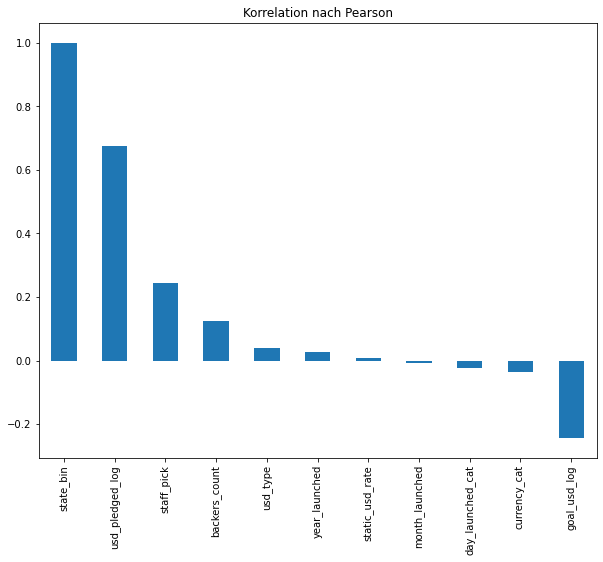

In [77]:
# correlation
basis=df_basismodel.corr(method='pearson')['state_bin'].sort_values(axis=0, ascending=False)
basis.plot(kind='bar',figsize=(10,8),title='Korrelation nach Pearson')

## Correlations with dummyvariables

In [78]:
# Einführung von Dummyvariablen für die Korrelationsanalyse
main_dummy= pd.get_dummies(df_basismodel['maincategory_name'], prefix='sub', drop_first=True)

In [79]:
main_dum = df_basismodel.drop(['maincategory_name'], axis=1)

In [82]:
main_dum = pd.concat([main_dum,main_dummy], axis=1)

<AxesSubplot:title={'center':'Korrelation nach Pearson'}>

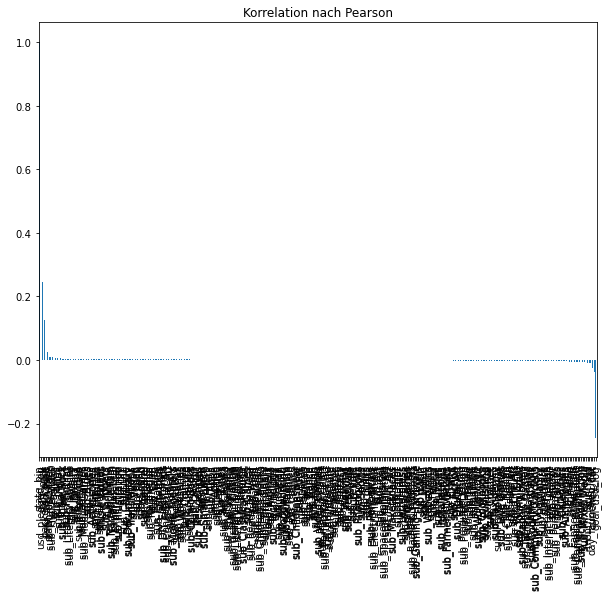

In [83]:
# correlation
basis_dum=main_dum.corr(method='pearson')['state_bin'].sort_values(axis=0, ascending=False)
basis_dum.plot(kind='bar',figsize=(10,8),title='Korrelation nach Pearson')

In [75]:
df.maincategory_name.nunique()

16

## Definition of a further model

## Future work

Our future work will be to discuss the following items:
- **name**: name of the project
- **blurb**: short description of the project
- **profile**: contains a couple of profilerelated features
- **photo**: information about photos attached to the project
- **slug**: search engine text, contains a couple of features